In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from keras.models import Model, load_model, save_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.preprocessing.image import array_to_img, img_to_array, load_img

from utils import *
from unet_model import *
from custom_metrics import *
from lovasz_loss import *

C:\Users\wlyip\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# basic config
img_size_ori = 101
img_size_target = 101

In [3]:
# load csv dataset
train_df = pd.read_csv('datasets/train.csv', index_col='id', usecols=[0])
depths_df = pd.read_csv('datasets/depths.csv', index_col='id')
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [4]:
# load train images data
train_df['images'] = [np.array(load_img('datasets/train/images/{}.png'.format(idx), 
                                        color_mode='grayscale')) / 255. for idx in tqdm(train_df.index)]

100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:24<00:00, 163.85it/s]


In [5]:
# load train masks data
train_df['masks'] = [np.array(load_img('datasets/train/masks/{}.png'.format(idx), 
                                       color_mode='grayscale')) / 255 for idx in tqdm(train_df.index)]

100%|████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:02<00:00, 1707.57it/s]


In [6]:
# create new variables coverage and coverage_class
train_df['coverage'] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)
train_df['coverage_class'] = train_df.coverage.map(cov_to_class)

In [7]:
# split train data into train set and validation set by coverage_class
ids_train, ids_valid, X_train, X_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = \
train_test_split(train_df.index.values, 
                 np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
                 np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
                 train_df.coverage.values, 
                 train_df.z.values, 
                 test_size=0.2, stratify=train_df.coverage_class, random_state=555)

In [8]:
# data augmentation on train set
X_train = data_augmentation(X_train)
y_train = data_augmentation(y_train)

In [9]:
# model
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16)

model1 = Model(input_layer, output_layer)

c = optimizers.adam(lr = 0.005)
model1.compile(loss='binary_crossentropy', optimizer=c, metrics=[my_iou_metric])

model1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 101, 101, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 101, 101, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 101, 101, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 25, 25, 32)   0           max_pooling2d_2[0][0]            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 25, 25, 64)   18496       dropout_2[0][0]                  
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 25, 25, 64)   256         conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 25, 25, 64)   0           batch_normalization_11[0][0]     
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 25, 25, 64)   36928       activation_11[0][0]              
__________

__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 6, 6, 256)    295168      dropout_4[0][0]                  
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 6, 6, 256)    1024        conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 6, 6, 256)    0           batch_normalization_21[0][0]     
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 6, 6, 256)    590080      activation_21[0][0]              
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 6, 6, 256)    1024        conv2d_22[0][0]                  
__________

concatenate_2 (Concatenate)     (None, 25, 25, 128)  0           conv2d_transpose_2[0][0]         
                                                                 activation_15[0][0]              
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 25, 25, 128)  0           concatenate_2[0][0]              
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 25, 25, 64)   73792       dropout_6[0][0]                  
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 25, 25, 64)   256         conv2d_31[0][0]                  
__________________________________________________________________________________________________
activation_31 (Activation)      (None, 25, 25, 64)   0           batch_normalization_31[0][0]     
__________

activation_40 (Activation)      (None, 50, 50, 32)   0           batch_normalization_40[0][0]     
__________________________________________________________________________________________________
conv2d_transpose_4 (Conv2DTrans (None, 101, 101, 16) 4624        activation_40[0][0]              
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 101, 101, 32) 0           conv2d_transpose_4[0][0]         
                                                                 activation_5[0][0]               
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 101, 101, 32) 0           concatenate_4[0][0]              
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 101, 101, 16) 4624        dropout_8[0][0]                  
__________

In [11]:
%%time
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode = 'max',patience=15, verbose=1)
model_checkpoint = ModelCheckpoint('model1.model', monitor='val_my_iou_metric', mode='max',
                                   save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode='max', factor=0.5, patience=5,
                              min_lr=0.0001, verbose=1)

epochs = 100
batch_size = 8

history = model1.fit(X_train, y_train,
                     validation_data = [X_valid, y_valid], 
                     epochs=epochs, 
                     batch_size=batch_size, 
                     callbacks=[early_stopping, model_checkpoint, reduce_lr],
                     verbose=2)

Train on 6400 samples, validate on 800 samples
Epoch 1/100
 - 157s - loss: 0.3838 - my_iou_metric: 0.4371 - val_loss: 0.7046 - val_my_iou_metric: 0.1115

Epoch 00001: my_iou_metric improved from -inf to 0.43714, saving model to model1.model
Epoch 2/100
 - 156s - loss: 0.3306 - my_iou_metric: 0.4910 - val_loss: 0.2898 - val_my_iou_metric: 0.5594

Epoch 00002: my_iou_metric improved from 0.43714 to 0.49098, saving model to model1.model
Epoch 3/100
 - 156s - loss: 0.2881 - my_iou_metric: 0.5112 - val_loss: 0.3181 - val_my_iou_metric: 0.4110

Epoch 00003: my_iou_metric improved from 0.49098 to 0.51117, saving model to model1.model
Epoch 4/100
 - 156s - loss: 0.2615 - my_iou_metric: 0.5408 - val_loss: 0.3218 - val_my_iou_metric: 0.4617

Epoch 00004: my_iou_metric improved from 0.51117 to 0.54077, saving model to model1.model
Epoch 5/100
 - 156s - loss: 0.2482 - my_iou_metric: 0.5598 - val_loss: 0.2410 - val_my_iou_metric: 0.6189

Epoch 00005: my_iou_metric improved from 0.54077 to 0.55978, 

Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
Epoch 44/100
 - 155s - loss: 0.0830 - my_iou_metric: 0.7698 - val_loss: 0.1291 - val_my_iou_metric: 0.7788

Epoch 00044: my_iou_metric improved from 0.75636 to 0.76980, saving model to model1.model
Epoch 45/100
 - 156s - loss: 0.0799 - my_iou_metric: 0.7729 - val_loss: 0.1372 - val_my_iou_metric: 0.7649

Epoch 00045: my_iou_metric improved from 0.76980 to 0.77286, saving model to model1.model
Epoch 46/100
 - 155s - loss: 0.0803 - my_iou_metric: 0.7717 - val_loss: 0.1405 - val_my_iou_metric: 0.7826

Epoch 00046: my_iou_metric did not improve from 0.77286
Epoch 47/100
 - 155s - loss: 0.0765 - my_iou_metric: 0.7762 - val_loss: 0.1281 - val_my_iou_metric: 0.7790

Epoch 00047: my_iou_metric improved from 0.77286 to 0.77616, saving model to model1.model
Epoch 48/100
 - 155s - loss: 0.0809 - my_iou_metric: 0.7743 - val_loss: 0.1357 - val_my_iou_metric: 0.7799

Epoch 00048: my_iou_metric did not improve from 0.7761

The first stage of training achieves 0.80083.

In [13]:
model1 = load_model('model1.model', 
                    custom_objects={'my_iou_metric':my_iou_metric})
# remove activation layer and use lovasz loss
input_x = model1.layers[0].input

output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.adam(lr=0.01)

model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 101, 101, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 101, 101, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 101, 101, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 25, 25, 32)   0           max_pooling2d_2[0][0]            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 25, 25, 64)   18496       dropout_2[0][0]                  
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 25, 25, 64)   256         conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 25, 25, 64)   0           batch_normalization_11[0][0]     
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 25, 25, 64)   36928       activation_11[0][0]              
__________

__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 6, 6, 256)    295168      dropout_4[0][0]                  
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 6, 6, 256)    1024        conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_21 (Activation)      (None, 6, 6, 256)    0           batch_normalization_21[0][0]     
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 6, 6, 256)    590080      activation_21[0][0]              
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, 6, 6, 256)    1024        conv2d_22[0][0]                  
__________

concatenate_2 (Concatenate)     (None, 25, 25, 128)  0           conv2d_transpose_2[0][0]         
                                                                 activation_15[0][0]              
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 25, 25, 128)  0           concatenate_2[0][0]              
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 25, 25, 64)   73792       dropout_6[0][0]                  
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 25, 25, 64)   256         conv2d_31[0][0]                  
__________________________________________________________________________________________________
activation_31 (Activation)      (None, 25, 25, 64)   0           batch_normalization_31[0][0]     
__________

activation_40 (Activation)      (None, 50, 50, 32)   0           batch_normalization_40[0][0]     
__________________________________________________________________________________________________
conv2d_transpose_4 (Conv2DTrans (None, 101, 101, 16) 4624        activation_40[0][0]              
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 101, 101, 32) 0           conv2d_transpose_4[0][0]         
                                                                 activation_5[0][0]               
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 101, 101, 32) 0           concatenate_4[0][0]              
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 101, 101, 16) 4624        dropout_8[0][0]                  
__________

In [14]:
%%time
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=30, verbose=1)
model_checkpoint = ModelCheckpoint('final_model.model',monitor='val_my_iou_metric_2', 
                                   mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode='max', factor=0.5, patience=5, 
                              min_lr=0.00005, verbose=1)
epochs = 100
batch_size = 8

history = model.fit(X_train, y_train,
                    validation_data=[X_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, reduce_lr, early_stopping], 
                    verbose=2)

Train on 6400 samples, validate on 800 samples
Epoch 1/100
 - 240s - loss: 0.1789 - my_iou_metric_2: 0.7366 - val_loss: 0.1744 - val_my_iou_metric_2: 0.7436

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.74362, saving model to final_model.model
Epoch 2/100
 - 226s - loss: 0.1173 - my_iou_metric_2: 0.7406 - val_loss: 0.1312 - val_my_iou_metric_2: 0.7379

Epoch 00002: val_my_iou_metric_2 did not improve from 0.74362
Epoch 3/100
 - 226s - loss: 0.0960 - my_iou_metric_2: 0.7447 - val_loss: 0.2778 - val_my_iou_metric_2: 0.7002

Epoch 00003: val_my_iou_metric_2 did not improve from 0.74362
Epoch 4/100
 - 226s - loss: 0.0874 - my_iou_metric_2: 0.7455 - val_loss: -2.5421e-02 - val_my_iou_metric_2: 0.7790

Epoch 00004: val_my_iou_metric_2 improved from 0.74362 to 0.77900, saving model to final_model.model
Epoch 5/100
 - 226s - loss: 0.0980 - my_iou_metric_2: 0.7447 - val_loss: 0.1068 - val_my_iou_metric_2: 0.7535

Epoch 00005: val_my_iou_metric_2 did not improve from 0.77900
Epoch 6/


Epoch 00042: val_my_iou_metric_2 did not improve from 0.81975
Epoch 43/100
 - 229s - loss: -4.1952e-01 - my_iou_metric_2: 0.8480 - val_loss: -2.1305e-01 - val_my_iou_metric_2: 0.8155

Epoch 00043: val_my_iou_metric_2 did not improve from 0.81975
Epoch 44/100
 - 229s - loss: -4.1748e-01 - my_iou_metric_2: 0.8478 - val_loss: -2.1235e-01 - val_my_iou_metric_2: 0.8175

Epoch 00044: val_my_iou_metric_2 did not improve from 0.81975
Epoch 45/100
 - 229s - loss: -4.2836e-01 - my_iou_metric_2: 0.8497 - val_loss: -2.1344e-01 - val_my_iou_metric_2: 0.8180

Epoch 00045: val_my_iou_metric_2 did not improve from 0.81975
Epoch 46/100
 - 229s - loss: -4.2574e-01 - my_iou_metric_2: 0.8507 - val_loss: -2.1788e-01 - val_my_iou_metric_2: 0.8142

Epoch 00046: val_my_iou_metric_2 did not improve from 0.81975

Epoch 00046: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
Epoch 47/100
 - 229s - loss: -4.2427e-01 - my_iou_metric_2: 0.8497 - val_loss: -2.1246e-01 - val_my_iou_metric_2: 0.814

The final model achieves 0.81437.

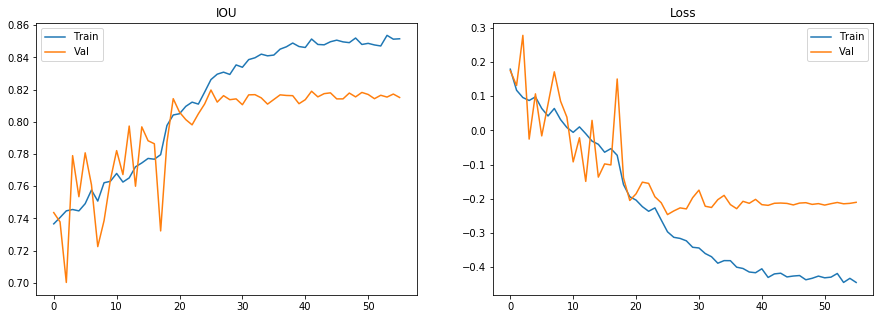

In [17]:
fig, (ax_score, ax_loss) = plt.subplots(1, 2, figsize=(15, 5))

ax_score.plot(history.epoch, history.history['my_iou_metric_2'], label='Train')
ax_score.plot(history.epoch, history.history['val_my_iou_metric_2'], label='Val')
ax_score.set_title('IOU')
ax_score.legend()

ax_loss.plot(history.epoch, history.history['loss'], label='Train')
ax_loss.plot(history.epoch, history.history['val_loss'], label='Val')
ax_loss.set_title('Loss')
ax_loss.legend()

In [18]:
# load the best model
model = load_model('final_model.model',custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

In [19]:
# prediction for threshold tuning
preds_valid = predict_result(model, X_valid, img_size_target)

In [20]:
# choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm(thresholds)])
print(ious)

  0%|                                                                                           | 0/31 [00:00<?, ?it/s]C:\Users\wlyip\Anaconda3\lib\site-packages\numpy\lib\histograms.py:708: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)
100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:28<00:00,  1.08it/s]


[0.817    0.81825  0.818    0.817625 0.81825  0.81875  0.819    0.81925
 0.8185   0.818375 0.8185   0.818125 0.818875 0.818    0.81925  0.819625
 0.819125 0.81875  0.818375 0.81775  0.818625 0.817875 0.816625 0.815375
 0.81625  0.817375 0.816625 0.81725  0.815375 0.8145   0.8125  ]


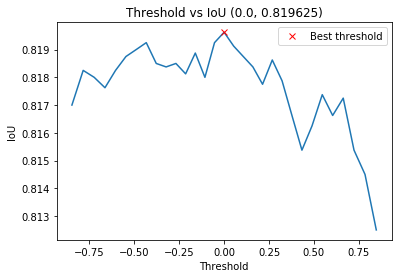

In [21]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, 'xr', label='Best threshold')
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [22]:
# load test dataset
X_test = np.array([(np.array(load_img("datasets/test/images/{}.png".format(idx), 
                                      color_mode='grayscale'))) / 255 for idx in tqdm(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

100%|████████████████████████████████████████████████████████████████████████████| 18000/18000 [03:38<00:00, 82.31it/s]


In [23]:
# prediction
preds_test = predict_result(model, X_test, img_size_target)

In [24]:
# rle encoding
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm(test_df.index.values))}

100%|██████████████████████████████████████████████████████████████████████████| 18000/18000 [00:11<00:00, 1631.44it/s]


In [26]:
sub = pd.DataFrame.from_dict(pred_dict, orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission_file.csv')